In [ ]:
!pip install transformers
!pip install gensim

In [ ]:
import numpy as np
import pandas as pd

import re
import string

import transformers
from transformers import BertTokenizer, BertModel
import gensim
import gensim.downloader

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


## Text Processing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ay2324 sem1/cs3244/project/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Null removals

In [ ]:
print(f"initial dataframe has {len(df)} rows.")
null_rows = df[df.isnull().values.any(1)]
print(f"dataframe has {len(null_rows)} null rows.")
df.dropna(how='any', inplace=True)
print(f"dataframe has {len(df)} rows after removing null values.")

initial dataframe has 404290 rows.
dataframe has 3 null rows.
dataframe has 404287 rows after removing null values.


In [ ]:
num_samples = len(df)
num_samples

404287

### Splitting

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

In [ ]:
# split into train/val, test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((258743, 5), (64686, 5), (80858, 5))

### Cleaning

In [ ]:
def clean_text(text):
    text = text.lower() # lower case
    text = re.sub('\s+\n+', ' ', text)
    text = re.sub(f"[{''.join(char for char in string.punctuation if char != '?')}]", ' ', text) # remove punctuation
    text = re.sub(r'[^a-zA-Z0-9\s?]', ' ', text) # remove special chars

    return text

demo_qn = "What's the meaning of life?"
clean_text(demo_qn)

'what s the meaning of life?'

In [ ]:
X_train['q1_cleaned'] = X_train['question1'].apply(clean_text)
X_train['q2_cleaned'] = X_train['question2'].apply(clean_text)
X_train.head(10)

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned
217908,217908,184295,83786,"Where can I find the uncut, uncensored Fifty S...",What's the best way to see Fifty Shades of Gre...,where can i find the uncut uncensored fifty s...,what s the best way to see fifty shades of gre...
103880,103880,171594,171595,"In the Quora iPhone app, is there a way to see...",How can I filter my content to see which quest...,in the quora iphone app is there a way to see...,how can i filter my content to see which quest...
252876,252876,158209,367298,College Applications: What does it take to get...,How much score does it take in the SATs (SAT 2...,college applications what does it take to get...,how much score does it take in the sats sat 2...
166262,166262,258027,258028,Which IIT is best for aeronautical engineering?,How can progress a civildroftman to civilengin...,which iit is best for aeronautical engineering?,how can progress a civildroftman to civilengin...
146340,146340,231187,231188,What is the legality behind copying and pastin...,Is it legal to copy news from other sites?,what is the legality behind copying and pastin...,is it legal to copy news from other sites?
332298,332298,432679,62027,What is the size of a profile photo on Instagram?,How can I see a full-size profile picture of s...,what is the size of a profile photo on instagram?,how can i see a full size profile picture of s...
217255,217255,323566,100138,What order should I watch DC movies?,What is the order of the Alien movies? Should ...,what order should i watch dc movies?,what is the order of the alien movies? should ...
309217,309217,433171,235300,The U.S. Treasury Department mints a American ...,"Why do US banks not accept coins, considering ...",the u s treasury department mints a american ...,why do us banks not accept coins considering ...
185878,185878,214968,283666,Why do people keep their black money in Swiss ...,Why is black money kept in Swiss bank accounts?,why do people keep their black money in swiss ...,why is black money kept in swiss bank accounts?
140998,140998,223948,223949,Do Jews believe in the plagues of Egypt?,Do israeli jews believe in the messiah or not?,do jews believe in the plagues of egypt?,do israeli jews believe in the messiah or not?


### Question Length Analysis

In [ ]:
# find word counts of questions
X_train['q1_len'] = X_train['q1_cleaned'].apply(lambda x: len(str(x).split()))
X_train['q2_len'] = X_train['q2_cleaned'].apply(lambda x: len(str(x).split()))
X_train.head(10)

,id,qid1,qid2,question1,question2,q1_cleaned,q2_cleaned,q1_len,q2_len
217908,217908,184295,83786,"Where can I find the uncut, uncensored Fifty S...",What's the best way to see Fifty Shades of Gre...,where can i find the uncut uncensored fifty s...,what s the best way to see fifty shades of gre...,13,13
103880,103880,171594,171595,"In the Quora iPhone app, is there a way to see...",How can I filter my content to see which quest...,in the quora iphone app is there a way to see...,how can i filter my content to see which quest...,20,16
252876,252876,158209,367298,College Applications: What does it take to get...,How much score does it take in the SATs (SAT 2...,college applications what does it take to get...,how much score does it take in the sats sat 2...,14,26
166262,166262,258027,258028,Which IIT is best for aeronautical engineering?,How can progress a civildroftman to civilengin...,which iit is best for aeronautical engineering?,how can progress a civildroftman to civilengin...,7,7
146340,146340,231187,231188,What is the legality behind copying and pastin...,Is it legal to copy news from other sites?,what is the legality behind copying and pastin...,is it legal to copy news from other sites?,18,9
332298,332298,432679,62027,What is the size of a profile photo on Instagram?,How can I see a full-size profile picture of s...,what is the size of a profile photo on instagram?,how can i see a full size profile picture of s...,10,13
217255,217255,323566,100138,What order should I watch DC movies?,What is the order of the Alien movies? Should ...,what order should i watch dc movies?,what is the order of the alien movies? should ...,7,18
309217,309217,433171,235300,The U.S. Treasury Department mints a American ...,"Why do US banks not accept coins, considering ...",the u s treasury department mints a american ...,why do us banks not accept coins considering ...,52,13
185878,185878,214968,283666,Why do people keep their black money in Swiss ...,Why is black money kept in Swiss bank accounts?,why do people keep their black money in swiss ...,why is black money kept in swiss bank accounts?,10,9
140998,140998,223948,223949,Do Jews believe in the plagues of Egypt?,Do israeli jews believe in the messiah or not?,do jews believe in the plagues of egypt?,do israeli jews believe in the messiah or not?,8,9


In [ ]:
X_train['q1_len'].describe()

count    258743.000000
mean         11.155359
std           5.595920
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         128.000000
Name: q1_len, dtype: float64

In [ ]:
X_train['q2_len'].describe()

count    258743.000000
mean         11.378329
std           6.421293
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         248.000000
Name: q2_len, dtype: float64

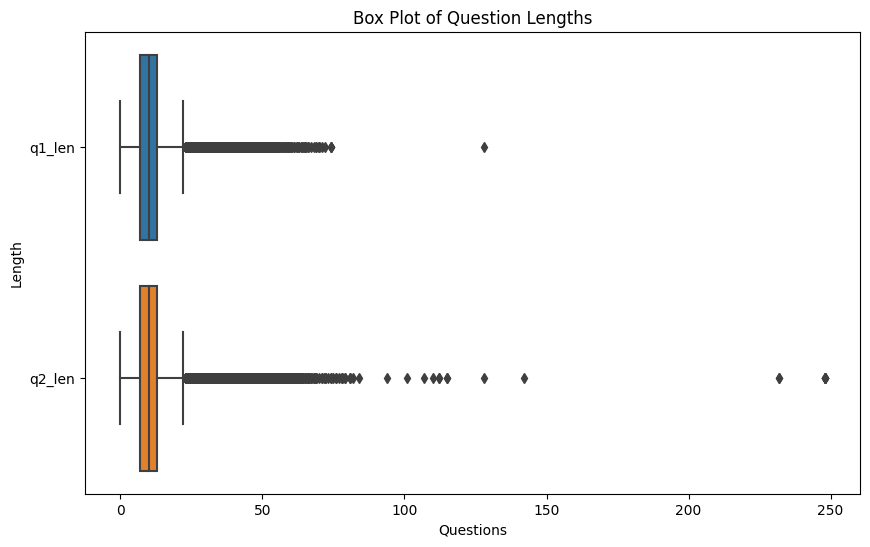

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[['q1_len', 'q2_len']], orient='h')
plt.title('Box Plot of Question Lengths')
plt.xlabel('Questions')
plt.ylabel('Length')
plt.show()

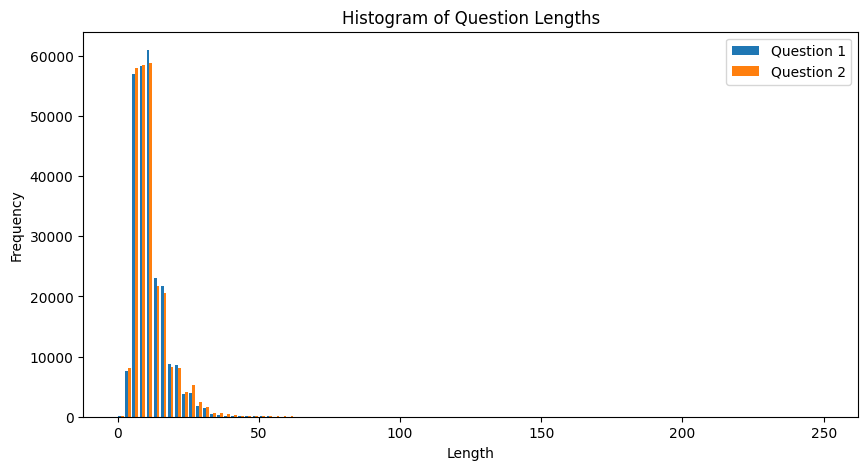

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist([X_train['q1_len'], X_train['q2_len']], bins=100, label=['Question 1', 'Question 2'], range=(0, 250))
plt.title('Histogram of Question Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Determining Ideal Sequence Length

In [ ]:
q1_len = X_train['q1_len']
q2_len = X_train['q2_len']

q1_iqr = q1_len.quantile(0.75) - q1_len.quantile(0.25)
q1_outlier = q1_len.quantile(0.75) + 1.5 * q1_iqr

q2_iqr = q2_len.quantile(0.75) - q2_len.quantile(0.25)
q2_outlier = q2_len.quantile(0.75) + 1.5 * q2_iqr
print(f"question 1 length outlier: {q1_outlier}")
print(f"question 2 length outlier: {q2_outlier}")

question 1 length outlier: 22.0
question 2 length outlier: 22.0


Both questions lengths are such that the outlier value (according to the $1.5 \cdot IQR$ rule) is 22 words.

We will choose a sequnce length of 60 to be safe.

## BERT

In [ ]:
MAX_SEQUENCE_LENGTH = 60

class BertUtilities:
    def __init__(self, model_name='bert-base-uncased', trainable=False):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.bert = BertModel.from_pretrained(model_name, output_hidden_states=True)

        if not trainable:
            for param in self.bert.parameters():
                param.requires_grad = False

    def encode_question(self, question):
        tokenizer_output = self.tokenizer(question, return_tensors="pt", add_special_tokens=True, max_length=MAX_SEQUENCE_LENGTH, padding='max_length', truncation=True, return_attention_mask=True)
        return {
            'input_ids': tokenizer_output['input_ids'],
            'attention_mask': tokenizer_output['attention_mask']
        }

    def __call__(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state
        return embeddings

In [ ]:
bert = BertUtilities()

In [ ]:
# run this
X_train[['q1_input_ids', 'q1_attention_masks']] = X_train['q1_cleaned'].apply(lambda q: pd.Series(bert.encode_question(q)))
X_train[['q2_input_ids', 'q2_attention_masks']] = X_train['q2_cleaned'].apply(lambda q: pd.Series(bert.encode_question(q)))

demo code

In [ ]:
x = bert.encode_question(X_train.iloc[:5]['q1_cleaned'].tolist())

In [ ]:
y = X_train.iloc[:5]['q1_cleaned'].apply(lambda x: bert.encode_question(x)['input_ids'])

In [ ]:
x = X_train.iloc[:1]['q1_cleaned'].apply(bert)

In [ ]:
xdd = pd.DataFrame()
xdd

""


In [ ]:
xdd[['a', 'b']] = X_train.iloc[:5]['q1_cleaned'].apply(lambda q: pd.Series(bert.encode_question(q)))

In [ ]:
xdd

,a,b
217908,"[[tensor(101), tensor(2073), tensor(2064), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
103880,"[[tensor(101), tensor(1999), tensor(1996), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
252876,"[[tensor(101), tensor(2267), tensor(5097), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
166262,"[[tensor(101), tensor(2029), tensor(2462), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
146340,"[[tensor(101), tensor(2054), tensor(2003), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
# text = ["What is the meaning of life?", "How and where can I buy Steam and Amazon gift cards?"]
# text = "How and where can I buy Steam and Amazon gift cards?"
# tokenizer(text)
# encoded_input = tokenizer(text, return_tensors="pt", max_length=60, truncation=True, padding=True)
# output = model(**encoded_input, output_attentions=True)

{'input_ids': [[101, 2054, 2003, 1996, 3574, 1997, 2166, 1029, 102], [101, 2129, 1998, 2073, 2064, 1045, 4965, 5492, 1998, 9733, 5592, 5329, 1029, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
# encoded_input

{'input_ids': tensor([[ 101, 2054, 2003, 1996, 3574, 1997, 2166, 1029,  102,    0,    0,    0,
            0,    0],
        [ 101, 2129, 1998, 2073, 2064, 1045, 4965, 5492, 1998, 9733, 5592, 5329,
         1029,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## Siamese BERT with Mean Pooling, L1 Distance and FCN

In [ ]:
class L1DistanceLayer(nn.Module):

    def __init__(self):
        super(L1DistanceLayer, self).__init__()

    def forward(self, embedding1, embedding2):
        l1_dist = torch.abs(embedding1 - embedding2)
        return l1_dist

class MeanPoolingLayer(nn.Module):
    def __init__(self, dim):
        super(MeanPoolingLayer, self).__init__()
        self.dim = dim

    def forward(self, x):
        return torch.mean(x, dim=self.dim)

class SiameseNetwork(nn.Module):

    def __init__(self, embedding_dim, hidden_dim):
        super(SiameseNetwork, self).__init__()
        self.mean_pool = MeanPoolingLayer(dim=1)
        self.l1_distance = L1DistanceLayer()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, q1_bert_lhs, q2_bert_lhs):
        embedding1 = self.mean_pool(q1_bert_lhs) # can replace mean pooling with an LSTM?
        embedding2 = self.mean_pool(q2_bert_lhs)
        l1_dist = self.l1_distance(embedding1, embedding2)
        output = self.fc(l1_dist)
        return output

## Integrating Everything

### Dataset and Data Loader

In [ ]:
embedding_dim = 768

class DuplicateQuestionDataset(Dataset):

    def __init__(self, questions, labels):
        self.questions = questions
        self.labels = labels
        self.embedding_dim = embedding_dim

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q1_input_ids, q1_attention_mask, q2_input_ids, q2_attention_mask = self.questions[['q1_input_ids', 'q1_attention_masks', 'q2_input_ids' 'q2_attention_masks']].iloc[idx]

        q1_bert_lhs = bert(q1_input_ids, attention_mask=q1_attention_mask).last_hidden_state.to(device)
        q2_bert_lhs = bert(q2_input_ids, attention_mask=q2_attention_mask).last_hidden_state.to(device)

        label = torch.tensor(self.labels.iloc[idx]).to(device)

        return q1_bert_lhs, q2_bert_lhs, label

### Preprocess  Validation and Test Datasets

In [ ]:
X_val['q1_cleaned'] = X_val['question1'].apply(clean_text)
X_val['q2_cleaned'] = X_val['question2'].apply(clean_text)

# find word counts of questions
X_val['q1_len'] = X_val['q1_cleaned'].apply(lambda x: len(str(x).split()))
X_val['q2_len'] = X_val['q2_cleaned'].apply(lambda x: len(str(x).split()))

X_val[['q1_input_ids', 'q1_attention_masks']] = X_val['q1_cleaned'].apply(lambda q: pd.Series(bert.encode_question(q)))
X_val[['q2_input_ids', 'q2_attention_masks']] = X_val['q2_cleaned'].apply(lambda q: pd.Series(bert.encode_question(q)))

X_val.head(10)

In [ ]:
X_test['q1_cleaned'] = X_test['question1'].apply(clean_text)
X_test['q2_cleaned'] = X_test['question2'].apply(clean_text)

# find word counts of questions
X_test['q1_len'] = X_test['q1_cleaned'].apply(lambda x: len(str(x).split()))
X_test['q2_len'] = X_test['q2_cleaned'].apply(lambda x: len(str(x).split()))

X_test[['q1_input_ids', 'q1_attention_masks']] = X_test['q1_cleaned'].apply(lambda q: pd.Series(bert.encode_question(q)))
X_test[['q2_input_ids', 'q2_attention_masks']] = X_test['q2_cleaned'].apply(lambda q: pd.Series(bert.encode_question(q)))

X_test.head(10)

In [ ]:
# batch size
batch_size = 64

train_dataset = DuplicateQuestionDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DuplicateQuestionDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DuplicateQuestionDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Hyperparameters

In [ ]:
# LSTM hyperparameters
embedding_dim = 768
hidden_size = 600
num_layers = 1

learning_rate = 0.002

### Model Initialisation

In [ ]:
siamese_model = SiameseNetwork(embedding_dim, hidden_size).to(device)

siamese_model.train()

SiameseNetwork(
  (mean_pool): MeanPoolingLayer()
  (l1_distance): L1DistanceLayer()
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=600, bias=True)
    (1): ReLU()
    (2): Linear(in_features=600, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

### Optimizers & Loss

In [ ]:
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [ ]:
total_params = sum(p.numel() for p in siamese_model.parameters())
total_params

462001